# AnyoneAI - Sprint Project 01
> E-Commerce Data Pipeline

In this notebook we will first execute all the components of our ELT pipeline and then plot visualizations with the resulting information.


In [2]:
# Importing the necessary libraries
from pandas import DataFrame
from sqlalchemy import create_engine
from typing import Dict
from pathlib import Path
import pandas as pd

from sqlalchemy.engine.base import Engine
from src.transform import QueryEnum
from src import config
from src.transform import run_queries
from src.extract import extract
from src.load import load
from src.plots import (
    plot_freight_value_weight_relationship,
    plot_global_amount_order_status,
    plot_real_vs_predicted_delivered_time,
    plot_revenue_by_month_year,
    plot_revenue_per_state,
    plot_top_10_least_revenue_categories,
    plot_top_10_revenue_categories,
    plot_top_10_revenue_categories_ammount,
    plot_delivery_date_difference,
    plot_order_amount_per_day_with_holidays,
)

# Create the database sql file
Path(config.SQLITE_BD_ABSOLUTE_PATH).touch()

# Create the database connection
ENGINE = create_engine(rf"sqlite:///{config.SQLITE_BD_ABSOLUTE_PATH}", echo=False)

csv_folder = config.DATASET_ROOT_PATH
public_holidays_url = config.PUBLIC_HOLIDAYS_URL

# 1. Get the mapping of the csv files to the table names.
csv_table_mapping = config.get_csv_to_table_mapping()

# 2. Extract the data from the csv files, holidays and load them into the dataframes.
csv_dataframes = extract(csv_folder, csv_table_mapping, public_holidays_url)

load(data_frames=csv_dataframes, database=ENGINE)

query_results: Dict[str, DataFrame] = run_queries(database=ENGINE)

All dataframes have been loaded into the database.


In [5]:
# Crear la conexión a la base de datos
engine = create_engine(rf"sqlite:///{config.SQLITE_BD_ABSOLUTE_PATH}", echo=False)

# Cargar los datos desde la base de datos SQLite en DataFrames de pandas
customers_df = pd.read_sql_table('olist_customers', con=engine)
geolocation_df = pd.read_sql_table('olist_geolocation', con=engine)
order_items_df = pd.read_sql_table('olist_order_items', con=engine)
order_payments_df = pd.read_sql_table('olist_order_payments', con=engine)
order_reviews_df = pd.read_sql_table('olist_order_reviews', con=engine)
orders_df = pd.read_sql_table('olist_orders', con=engine)
products_df = pd.read_sql_table('olist_products', con=engine)
sellers_df = pd.read_sql_table('olist_sellers', con=engine)
product_category_name_translation_df = pd.read_sql_table('product_category_name_translation', con=engine)
public_holidays_df = pd.read_sql_table('public_holidays', con=engine)

# Mostrar las primeras filas de cada DataFrame

# print("\nSellers dataset:")
# sellers_df

# print("\nProduct Category Name Translation dataset:")
# product_category_name_translation_df

# print("\nPublic Holidays dataset:")
# public_holidays_df

In [7]:
print("Customers dataset:")
customers_df

Customers dataset:


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


In [8]:
print("\nGeolocation dataset:")
geolocation_df


Geolocation dataset:


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
...,...,...,...,...,...
1000158,99950,-28.068639,-52.010705,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS
1000161,99980,-28.388932,-51.846871,david canabarro,RS


In [17]:
query_december_2016 = """
WITH revenue AS (
    SELECT 
        strftime('%m', o.order_purchase_timestamp) AS month_no,
        strftime('%Y', o.order_purchase_timestamp) AS year,
        oi.price AS revenue
    FROM 
        olist_orders o
    JOIN 
        olist_order_items oi ON o.order_id = oi.order_id
)
SELECT 
    month_no,
    SUM(CASE WHEN year = '2016' THEN revenue ELSE 0 END) AS Year2016
FROM 
    revenue
WHERE 
    month_no = '12'
GROUP BY 
    month_no;
"""

# Ejecutar la consulta y cargar los resultados en un DataFrame
december_2016_df = pd.read_sql_query(query_december_2016, con=engine)
print(december_2016_df)


  month_no  Year2016
0       12      10.9


In [18]:
query_october_2016 = """
WITH revenue AS (
    SELECT 
        strftime('%m', o.order_purchase_timestamp) AS month_no,
        strftime('%Y', o.order_purchase_timestamp) AS year,
        oi.price AS revenue
    FROM 
        olist_orders o
    JOIN 
        olist_order_items oi ON o.order_id = oi.order_id
)
SELECT 
    month_no,
    SUM(CASE WHEN year = '2016' THEN revenue ELSE 0 END) AS Year2016
FROM 
    revenue
WHERE 
    month_no = '10'
GROUP BY 
    month_no;
"""

# Ejecutar la consulta y cargar los resultados en un DataFrame
october_2016_df = pd.read_sql_query(query_october_2016, con=engine)
print(october_2016_df)

  month_no  Year2016
0       10  49507.66


In [19]:
query_january_2016 = """
WITH revenue AS (
    SELECT 
        strftime('%m', o.order_purchase_timestamp) AS month_no,
        strftime('%Y', o.order_purchase_timestamp) AS year,
        oi.price AS revenue
    FROM 
        olist_orders o
    JOIN 
        olist_order_items oi ON o.order_id = oi.order_id
)
SELECT 
    month_no,
    SUM(CASE WHEN year = '2016' THEN revenue ELSE 0 END) AS Year2016
FROM 
    revenue
WHERE 
    month_no = '01'
GROUP BY 
    month_no;
"""

# Ejecutar la consulta y cargar los resultados en un DataFrame
january_2016_df = pd.read_sql_query(query_january_2016, con=engine)
print(january_2016_df)

  month_no  Year2016
0       01         0


In [14]:
print("\nOrders dataset:")
orders_df


Orders dataset:


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [9]:
print("\nOrder Items dataset:")
order_items_df


Order Items dataset:


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [10]:
print("\nOrder Payments dataset:")
order_payments_df


Order Payments dataset:


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54


In [11]:
print("\nOrder Reviews dataset:")
order_reviews_df


Order Reviews dataset:


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,None,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,None,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,None,None,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,None,None,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,None,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,None,None,2018-07-01 00:00:00,2018-07-02 12:59:13


In [13]:
print("\nProducts dataset:")
products_df


Products dataset:


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


In [33]:
# Transforming the revenue_by_month_year query to a table
revenue_by_month_year = query_results[QueryEnum.REVENUE_BY_MONTH_YEAR.value]
revenue_by_month_year

,month_no,month,Year2016,Year2017,Year2018
0,01,Jan,0.00,120312.87,950030.36
1,02,Feb,0.00,247303.02,844178.71
2,03,Mar,0.00,374344.30,983213.44
3,04,Apr,0.00,359927.23,996647.75
4,05,May,0.00,506071.14,996517.68
5,06,Jun,0.00,433038.60,865124.31
6,07,Jul,0.00,498031.48,895507.22
7,08,Aug,0.00,573971.68,854686.33
8,09,Sep,267.36,624401.69,145.00
9,10,Oct,49507.66,664219.43,0.00


In [10]:
# Transforming the top_10_revenue_categories query to a table
top_10_revenue_categories = query_results[QueryEnum.TOP_10_REVENUE_CATEGORIES.value]
top_10_revenue_categories

,Category,Num_order,Revenue
0,health_beauty,8647,1233131.72
1,watches_gifts,5493,1165898.98
2,bed_bath_table,9272,1023434.76
3,sports_leisure,7529,954673.55
4,computers_accessories,6529,888613.62
5,furniture_decor,6307,711927.69
6,housewares,5743,615628.69
7,cool_stuff,3559,610204.10
8,auto,3809,578849.35
9,toys,3803,471097.49


In [42]:
# Transforming the top_10_least_revenue_categories query to a table
top_10_least_revenue_categories = query_results[
    QueryEnum.TOP_10_LEAST_REVENUE_CATEGORIES.value
]
top_10_least_revenue_categories

,Category,Num_order,Revenue
0,security_and_services,2,283.29
1,fashion_childrens_clothes,7,519.95
2,cds_dvds_musicals,12,730.00
3,home_comfort_2,24,760.27
4,flowers,29,1110.04
5,diapers_and_hygiene,25,1500.79
6,arts_and_craftmanship,23,1814.01
7,la_cuisine,13,2054.99
8,fashion_sport,26,2094.52
9,fashio_female_clothing,36,2634.94


In [12]:
# Transforming the revenue_per_state query to a table
revenue_per_state = query_results[QueryEnum.REVENUE_PER_STATE.value]
revenue_per_state

,customer_state,Revenue
0,SP,5.066563e+06
1,RJ,1.759651e+06
2,MG,1.552482e+06
3,RS,7.287185e+05
4,PR,6.660635e+05
5,SC,5.070121e+05
6,BA,4.935841e+05
7,DF,2.964984e+05
8,GO,2.828367e+05
9,ES,2.686434e+05


##### 3.2 Delivery queries

In [13]:
# Transforming the delivery_date_difference query to a table
delivery_date_difference = query_results[QueryEnum.DELIVERY_DATE_DIFFERECE.value]
delivery_date_difference

,State,Delivery_Difference
0,AL,8
1,MA,9
2,SE,9
3,BA,10
4,CE,10
5,ES,10
6,MS,10
7,SP,10
8,DF,11
9,GO,11


In [14]:
# Transforming the real vs predicted delivered time query to a table per month and year
real_vs_estimated_delivered_time = query_results[
    QueryEnum.REAL_VS_ESTIMATED_DELIVERED_TIME.value
]
real_vs_estimated_delivered_time

,month_no,month,Year2016_real_time,Year2017_real_time,Year2018_real_time,Year2016_estimated_time,Year2017_estimated_time,Year2018_estimated_time
0,01,Jan,NaN,8.602918,15.330987,NaN,38.093287,26.605709
1,02,Feb,NaN,10.331250,14.672381,NaN,34.958037,26.100344
2,03,Mar,NaN,11.908795,15.365344,NaN,25.756345,22.557836
3,04,Apr,NaN,12.813702,15.366259,NaN,26.809681,23.012420
4,05,May,NaN,12.943527,11.861215,NaN,24.909502,22.418769
5,06,Jun,NaN,11.679506,11.721084,NaN,24.614169,27.801868
6,07,Jul,NaN,11.289015,9.149208,NaN,23.095980,22.123831
7,08,Aug,NaN,11.000487,8.741144,NaN,23.493587,16.407960
8,09,Sep,NaN,12.487484,40.148743,NaN,22.067024,16.967427
9,10,Oct,14.480048,11.757649,114.608503,55.310101,23.644691,30.519884


In [15]:
# Transforming the global ammount of order status query to a table
global_ammount_order_status = query_results[QueryEnum.GLOBAL_AMMOUNT_ORDER_STATUS.value]
global_ammount_order_status

,order_status,Ammount
0,approved,2
1,canceled,625
2,created,5
3,delivered,96478
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


In [16]:
orders_per_day_and_holidays = query_results[
    QueryEnum.ORDERS_PER_DAY_AND_HOLIDAYS_2017.value
]
orders_per_day_and_holidays

Ellipsis

In [17]:
freight_value_weight_relationship = query_results[
    QueryEnum.GET_FREIGHT_VALUE_WEIGHT_RELATIONSHIP.value
]

### 4. Plotting the query tables

Now, we will create plots from the different queries

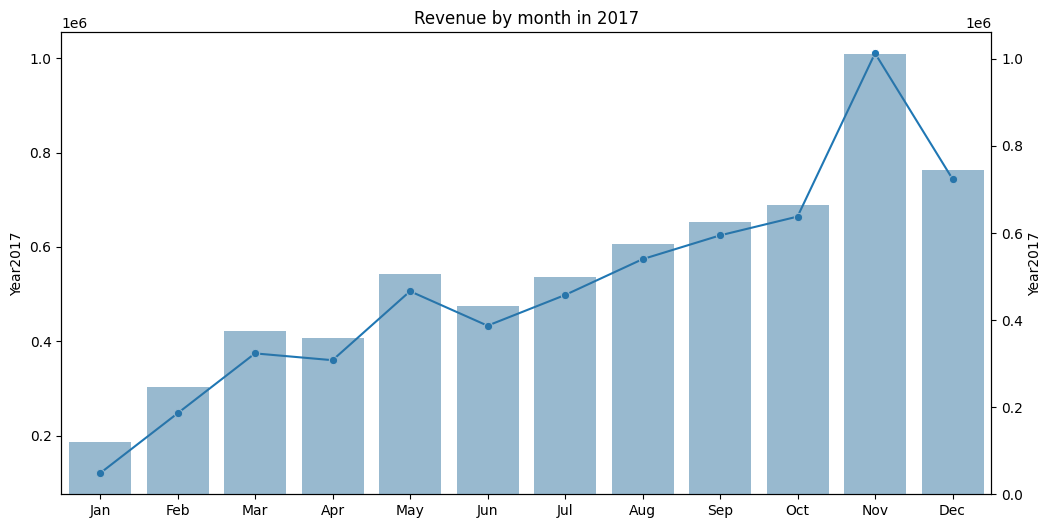

In [18]:
plot_revenue_by_month_year(revenue_by_month_year, 2017)

In [19]:
plot_top_10_revenue_categories(top_10_revenue_categories)

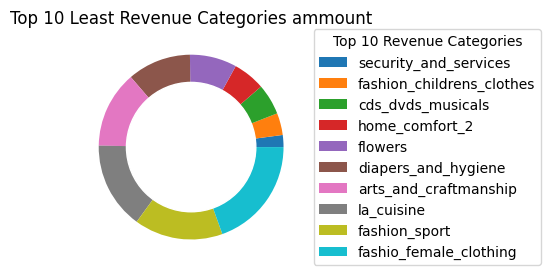

In [20]:
plot_top_10_least_revenue_categories(top_10_least_revenue_categories)

In [21]:
plot_revenue_per_state(revenue_per_state)

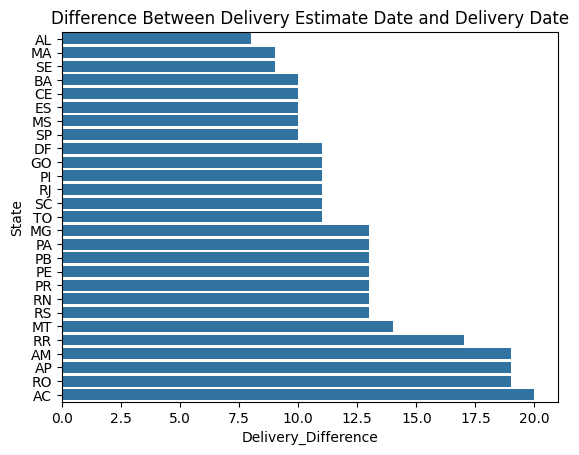

In [22]:
plot_delivery_date_difference(delivery_date_difference)

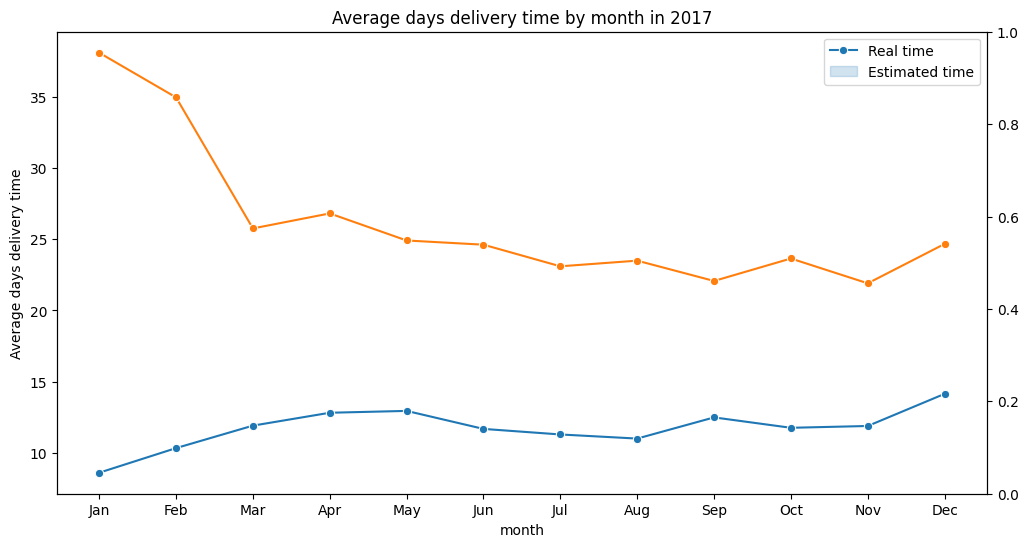

In [23]:
plot_real_vs_predicted_delivered_time(real_vs_estimated_delivered_time, year=2017)

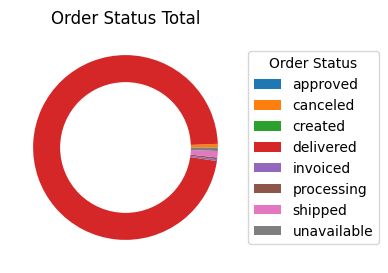

In [24]:
plot_global_amount_order_status(global_ammount_order_status)

In [25]:
plot_order_amount_per_day_with_holidays(orders_per_day_and_holidays)

NotImplementedError: 

The Orders per Day and Holidays plot you will code in src/plots.py has to be similar to this:

![The plot you will code will be similar to this:](images/orders_per_day_and_holidays.png "Orders per Day and Holidays")

4.1 Do you see any relationship between the Brazilian public holidays of 2017 and that year's purchases?

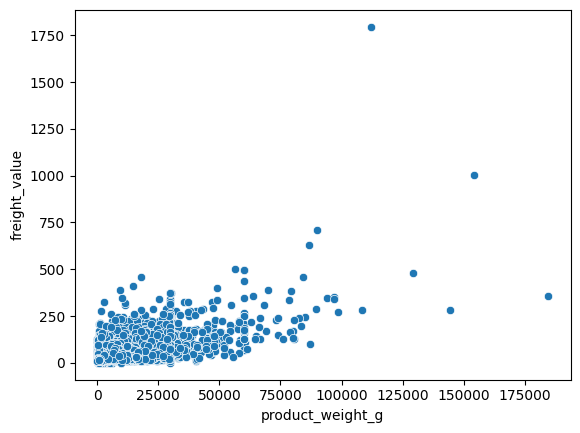

In [ ]:
plot_freight_value_weight_relationship(freight_value_weight_relationship)

The Freight Value and Weight Relationship plot you will code in src/plots.py has to be similar to this:

![The plot you will code will be similar to this:](images/freight_value_weight_relationship.png "Freight Value and Weight Relationship")

4.2 Do you see any correlation between the freight value and the product weight?